# read_block()

The `read_block()` function is the basic interface for reading block-level ECOG data from the UCSF Chang lab. It has one required parameter that defines the base data directory `basedir`. By default `read_block()` will read data from the 'ecogDS' subdirectory of `basedir`.

In [1]:
from ecog_ucsf.block import read_block
import numpy as np

basedir = '../../ecog/datasets/GP31_B40'
ds = read_block(basedir)
ds

ECBlock(basedir='../../ecog/datasets/GP31_B40', subdir='ecogDS', data=[[ 130.33782959  247.03282166  217.74197388 ...,  227.62039185
   253.04103088  129.75482178]
 [ 110.74650574  211.14225769  192.89465332 ...,  175.30302429
   186.76789856   94.83296204]
 [  99.78131866  188.86553955  169.49157715 ...,  184.86541748
   199.61947632  101.62522888]
 ..., 
 [ 155.18597412  291.36831665  249.77731323 ...,  325.25637817
   361.01947021  180.72859192]
 [-259.61843872 -491.78964233 -423.64752197 ..., -323.57369995
  -382.38088989 -196.47114563]
 [          nan           nan           nan ...,           nan
            nan           nan]], htkrate=400.0, badchan=[255, 112, 113, 114, 115, 123, 127])

`read_block()` returns an ECBlock object, which contains the block data as a numpy ndarray and associated metadata. The `data` attribute holds the ndarray. The first axis of this array is the electrode channels, and the second axis is sample times in the form of an integer index.

In [2]:
ds.data.shape

(256, 288801)

Other attributes you can read include the sample rate (converted to Hz) as reported by the `.htk` files, the the list of bad channels and bad time segments in the block, and the block's data directory and subdirectory.

In [3]:
print(ds.htkrate)
print(ds.badchan)
print(ds.badsegs)
print(ds.basedir)
print(ds.subdir)

400.0
[255, 112, 113, 114, 115, 123, 127]
           t1          t2
0    3.900000    4.400000
1  686.206406  686.699058
2  688.861252  690.736066
3  697.605822  698.002681
../../ecog/datasets/GP31_B40
ecogDS


Finally, the `ts` attribute contains the sample times of the data. 

In [4]:
print(ds.ts)

[  0.00000000e+00   2.50000000e-03   5.00000000e-03 ...,   7.21995000e+02
   7.21997500e+02   7.22000000e+02]


`ts` can be used to plot channel data with a proper time axis.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

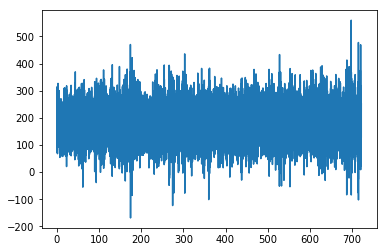

In [6]:
plt.plot(ds.ts, ds.data[0,:])

## The `subdir` parameter

Use the `subdir` parameter to read from a non-default subdirectory of `basedir`. The `.htk` files in `subdir` may contain data that is a different shape than is found in the default 'ecogDS' subdirectory.

In [7]:
subdir = 'HilbAA_70to150_8band'
bands = read_block(basedir, subdir)
bands

ECBlock(basedir='../../ecog/datasets/GP31_B40', subdir='ecogDS', data=[[[  4.22455025   5.36758852   5.80154228 ...,   4.39262581   5.51103258
     4.25414467]
  [  4.2146287    5.24366951   5.78416252 ...,   4.44086552   5.42778873
     4.1641655 ]
  [  4.18704987   5.09346533   5.7275176  ...,   4.4530158    5.30415964
     4.02637386]
  ..., 
  [  4.15087366   5.57430077   5.61382198 ...,   4.02628422   5.50698853
     4.20953608]
  [  4.1921711    5.53314447   5.71599436 ...,   4.18471861   5.55061865
     4.27777195]
  [  4.21693707   5.46424341   5.77882814 ...,   4.30722809   5.55216503
     4.29264069]]

 [[  3.09665585   3.61621547   3.19286013 ...,   2.23635387   2.08436179
     3.25961304]
  [  3.07151604   3.57516837   3.20979118 ...,   2.28917551   2.01924372
     3.29403639]
  [  3.02797365   3.51849747   3.20194244 ...,   2.31910515   1.93104589
     3.30092835]
  ..., 
  [  3.05056548   3.64777827   2.98912096 ...,   1.94276071   2.13781428
     3.0026288 ]
  [  3.08691

The `.htk` files in 'HilbAA_70to150_8band' contain 2D data, with sample values in 8 frequency bands. The axes of the output ndarray data are now (channels, sample_times, bands).

In [8]:
bands.data.shape

(256, 288801, 8)

## The `converter` parameter.

The `converter` parameter may be used to apply a function to the data read from the `.htk` files on a per-channel basis. This function may change the shape of the input data, as long as the output shapes of all the channels are compatible with each other and can be compiled into a single output ndarray.

As an example, we'll use `decimate()` to downsample the signals from the `ecogDS` subdirectory. `read_block()` provides the channel data (a numpy ndarray) as the input to the converter function. In the example a lambda function calls `decimate()` on this ndarray and supplies additional parameters `q`, `axis`, and `zero_phase`.

In [9]:
from scipy.signal import decimate

In [10]:
dec = read_block(
    basedir,
    converter=lambda chan: decimate(chan, q=10, axis=0, zero_phase=True)
)
dec.data.shape

(256, 28881)

The result is the same as the `ds` output from before, except the length of the second axis has been reduced by a factor of 10, as seen by inspecting the data shape.

`read_block()` also automatically detects when a `converter` function changes the number of samples and sets the `datarate` attribute accordingly.

In [11]:
print(dec.datarate == dec.htkrate)
print(dec.htkrate)
print(dec.datarate)

False
400.0
40.00124653307987


### Notes about `converter`

There are several important points to observe if you apply a `converter` function:

1. The converter function applies separately to each channel as the corresponding `.htk` file is read. It is not applied to the entire output ndarray that contains all of the channels after it has been assembled.
1. The axis index used in the converter function refers to the axis location in the *input* ndarray of a single channel, not the location in the *output* ndarray of all channels. The `axis` parameter in the preceding example illustrates this point. The input ndarrays for each channel are 1D and therefore `decimate()` must operate on axis 0. But in the output array, axis 1 is the axis that shows the effect of downsampling.
1. The `datarate` attribute is calculated by scaling `htkrate` by the ratio of output samples to input samples. As a result you should expect slightly different `datarate` values on a block-to-block basis for a given decimation factor. This is because downsampling is a many-to-one mapping, meaning that there is more than one input signal duration that maps to a downsampled signal of length N. For example, we should expect 10 different input signal lengths to map to a length N signal when we call `decimate()` with a factor of 10. All channels in a single block have the same `datarate`.


### Reducing dimensionality

The `converter` function can also reduce the dimensionality of the input arrays. For example, numpy's `mean()` method can reduce the 2D data found in the 'HilbAA_70to150_8band' subdirectory by producing an average of all the frequency bands. As we saw earlier in `bands`, the first axis of each channel corresponds to sample times and the second corresponds to frequency bands (these correspond to axis 1 and axis 2 of `bands.data`, respectively; axis 0 of `bands.data` corresponds to channels).

For each *input* channel the sample times are contained in axis 0 and the frequency bands are in axis 1. If we take the mean along axis 1, then the result is an output ndarray with axes (channels, sample_times) where the values are the mean value of the 8 frequency bands per-channel and per-sample_time.

In [12]:
mn = read_block(
    basedir,
    subdir,
    converter=lambda chan: chan.mean(axis=1)
)
mn.data.shape

(256, 288801)

It's also possible to reduce the dimensionality of a dataset and reduce the length of a dimension in a single converter function. Here the dimensionality is reduced by `mean()` and the length of one axis by `decimate()`.

In [13]:
r2 = read_block(
    basedir,
    subdir,
    converter=
        lambda chan: decimate(
            chan.mean(axis=1), q=10, axis=0, zero_phase=True
        )
)
r2.data.shape

(256, 28881)

Additional calculations on the channel data can also be done. The final example calculates per-channel zscores of the downsampled mean data.

In [14]:
from scipy.stats import zscore
z = read_block(
    basedir,
    subdir,
    converter=
        # mean of bands -> downsample -> compute zscores
        lambda chan: zscore(
            decimate(
                chan.mean(axis=1), q=10, axis=0, zero_phase=True
            )
        )
)
z.data.shape

(256, 28881)

### Using a named function as the `converter`

The preceding examples illustrate anonymous converter functions. For more complicated calculations you may wish to define a named function, including a docstring.

In [15]:
def zscore_bands(data, datarate, trange, decimate_q=None):
    '''Calculate zscores for 8-channel frequency band data, using the values
in trange as the reference for calculating mean and standard deviation.
Also reduce dimensionality of channel data by taking mean of frequency bands.
Optionally downsample with decimate().

Parameters
----------
data : 2D ndarray
    8-band channel data to be zscored. The time axis must be axis 0, and the
    frequency bands are axis 1.

datarate : numeric
    The sample rate of data.

trange : list-like, two elements
    The start and end times to be used for indexing into data to calculate
    the reference mean and standard deviation for calculating zscores.
    
decimate_q : None (default) or int
    If int, the value to pass to `decimate()` as the `q` parameter for
    downsampling data. If None, do not downsample data.

Returns
-------
zscored_data : 1D ndarray
    A copy of the input data, reduced to 1D and zscored.
'''
    data = data.mean(axis=1)
    if decimate_q is not None:
        data = decimate(data, q=decimate_q, axis=0, zero_phase=True)
    tidx = np.around(np.array(trange) * datarate).astype(np.int)
    ref = data[np.arange(*tidx)]
    return (data - ref.mean()) / ref.std()

After the function is defined, use it in the `converter` parameter, and provide the additional parameters required by `zscore_bands`.

In [16]:
rate = 400.0
trange = [3.3, 3.8]
zref = read_block(
    basedir,
    subdir,
    converter=lambda chan: zscore_bands(
        chan, datarate=rate, trange=trange, decimate_q=10
    )
)
zref.data.shape

(256, 28881)

There is a bit of a chicken-or-the-egg problem here--you need to be aware of the sample rate of the `.htk` files before you invoke `read_block()`, and you also need to know the start and end times of `trange`. One way to get this information is to call `read_block()` without a converter function to get the ECBlock object it returns. You can inspect it to determine the sample rate in the `.htk` files, and you can look at the raw data it contains to select `trange`.

An alternative approach to calculating the zscores is to find the time period in the channel with the least activity and use that as the reference for calculating zscores. The time window is defined in number of samples, after downsampling.

In [17]:
def zscore_bands_auto(data, winsize, decimate_q=None):
    '''Calculate zscores for 8-channel frequency band data, by automatically
finding the time window with minimal electrode activity to use as the reference
for calculating mean and standard deviation. Also reduce dimensionality of channel
data by taking mean of frequency bands. Optionally downsample with decimate().

Parameters
----------
data : 2D ndarray
    8-band channel data to be zscored. The time axis must be axis 0, and the
    frequency bands are axis 1.

winsize : int
    The number of data samples (after downsampling) in the reference window. 
    
decimate_q : None (default) or int
    If int, the value to pass to `decimate()` as the `q` parameter for
    downsampling data. If None, do not downsample data.

Returns
-------
zscored_data : 1D ndarray
    A copy of the input data, reduced to 1D and zscored.
'''
    data = np.nanmean(data, axis=1)
    if decimate_q is not None:
        data = decimate(data, q=decimate_q, axis=0, zero_phase=True)
    # Activity is calculated by summing a rolling window of sample variances.
    # The window with the smallest sum shows the least activity.
    activity = np.convolve(
        np.nanvar(data, axis=0),
        np.ones(winsize),
        'valid'
    )
    minidx = activity.argmin()
    ref = data[np.arange(minidx, minidx + winsize)]
    return (data - np.nanmean(ref)) / np.nanstd(ref)

In [18]:
zaref = read_block(
    basedir,
    subdir,
    converter=lambda chan: zscore_bands_auto(
        chan, winsize=10, decimate_q=10
    )
)
zaref.data.shape

(256, 28881)

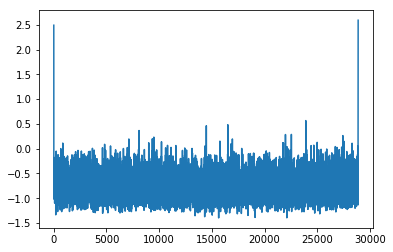

In [19]:
plt.plot(zaref.data[0,:])

## The `dtype` parameter

By default `read_block()` returns 32-bit float data. Use the `dtype` parameter to select a different type. For example, use np.float16 to reduce memory usage (and numerical precision).

In [20]:
bit16 = read_block(basedir, dtype=np.float16)
bit16.data.dtype

dtype('float16')

## Dealing with bad data

Sometimes there are problems during an acquisition that results in bad data values in one or more channels of electrode data, or during brief time segments across all channels. In the course of preprocessing, these problem channels and segments are recorded in the block's 'Artifacts' directory in the 'badChannels.txt' and 'badTimeSegments.mat' files.

By default, `read_block()` loads the information in these files and replaces the bad data values with `np.nan`. All of the ECBlock objects we have created so far contain `np.nan` replacement values.

In [21]:
np.isnan(ds.data).any()

True

The bad channel indexes are stored as a list of integers in the `badchan` attribute. (If you look at the 'badChannels.txt' file you will notice that the numbers don't match the indexes in `badchan`. This is because the text file numbers channels starting with 1, and numpy indexes start with 0, so the values in `badchan` are one less than the channel numbers in the file.)

In [22]:
ds.badchan

[255, 112, 113, 114, 115, 123, 127]

In [23]:
np.isnan(ds.data[112]).all()

True

The bad segments are stored as a Pandas dataframe in the `badsegs` attribute. Each row corresponds to a bad segment with a time that starts at `t1` and ends at `t2`.

In [24]:
ds.badsegs

,t1,t2
0,3.900000,4.400000
1,686.206406,686.699058
2,688.861252,690.736066
3,697.605822,698.002681


Additional attributes related to bad time segments are `badidx`, which provides index values along the time axis where bad sample values exist, and the complementary `badmask` and `goodmask` boolean indexes that can be used to select bad or good values from the time axis.

In [25]:
print(ds.badidx)
print(len(ds.badidx))
print(ds.badmask)
print(ds.badmask.sum())    # should be the same as len(ds.badidx)
print(ds.goodmask)

[  1560   1561   1562 ..., 279198 279199 279200]
1305
[False False False ..., False False False]
1305
[ True  True  True ...,  True  True  True]


The following plot contains only 'good' data values.

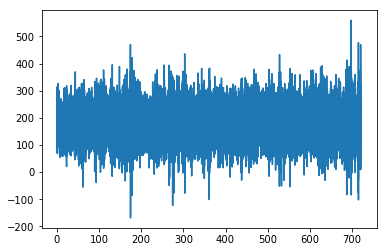

In [26]:
plt.plot(ds.ts[ds.goodmask], ds.data[0,ds.goodmask])

### The `replace` parameter

To turn off the default bad data behavior, include `replace=False` in the call to `read_block()`. The data in the ECBlock will have no replacements.

In [27]:
nonan = read_block(basedir, replace=False)
np.isnan(nonan.data).any()

False

Note that the `badchan` and `badsegs` attributes are populated even when `replace` is False.

In [28]:
print(nonan.badchan)
print(nonan.badsegs)

[255, 112, 113, 114, 115, 123, 127]
           t1          t2
0    3.900000    4.400000
1  686.206406  686.699058
2  688.861252  690.736066
3  697.605822  698.002681


The `badidx`, `badmask`, and `goodmask` attribute are also defined.

In [29]:
print(nonan.badidx)
print(len(nonan.badidx))
print(nonan.badmask)
print(nonan.badmask.sum())    # should be the same as len(ds.badidx)
print(nonan.goodmask)

[  1560   1561   1562 ..., 279198 279199 279200]
1305
[False False False ..., False False False]
1305
[ True  True  True ...,  True  True  True]


### The `artifact_dir` parameter

By default, `read_block()` looks in the 'Artifacts' subdirectory for the files that contain bad value information. Use the `artifact_dir` parameter to name a different subdirectory for these files.

### The `badchan` parameter

Use the `badchan` parameter to name the file containing bad channel information if it is not the default `badChannels.txt`.

### The `badsegs` parameter

Use the `badsegs` parameter to name the file with bad segment information if it is not the default `badTimeSegments.mat`. If the file you name is a `.lab` file, e.g. `bad_time_segments.lab`, then `read_block()` will parse it as a text file rather than a Matlab binary file.